# Capstone Project

Notebook for Data preparation, cleaning, checking, creating models, tunning them and evaluating the best one for our image classificator



In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import random
import numpy as np
from io import BytesIO
from PIL import Image
import requests
import urllib
from IPython.display import display

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow import keras
import tensorflow.lite as tflite
import PIL
import PIL.Image

import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange

%matplotlib inline



2023-12-18 21:55:43.837678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 21:55:43.923204: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-18 21:55:43.923220: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-18 21:55:44.376672: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Dataset information

Dataset can be downloaded from: https://www.tensorflow.org/datasets/catalog/eurosat#eurosatrgb_default_config

The dataset consists of 10 different types of lands. The goal of this project is to classify different images into 1 of those 10 different classes. The classes are:

1. "AnnualCrop"
1. "Forest"
1. "HerbaceousVegetation"
1. "Highway"
1. "Industrial"
1. "Pasture"
1. "PermanentCrop"
1. "Residential"
1. "River"
1. "SeaLake"

# EDA
## Data preparation

First we load the data

AnnualCrop


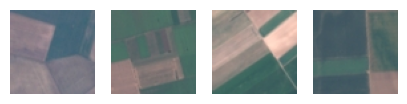

Forest


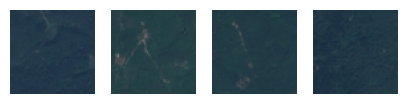

HerbaceousVegetation


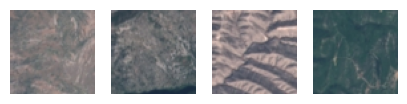

Highway


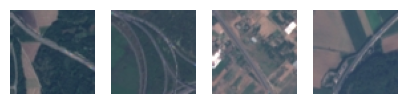

Industrial


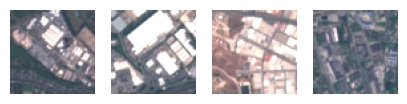

Pasture


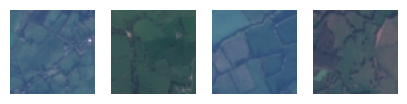

PermanentCrop


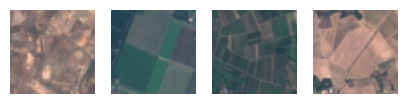

Residential


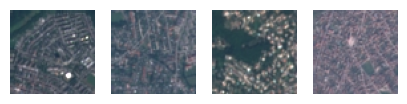

River


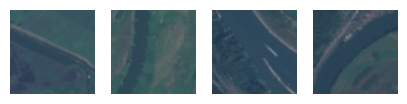

SeaLake


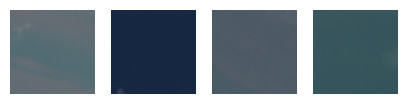

In [2]:
path = "EuroSAT_RGB/"
example = "Highway/Highway_15.jpg"
target_size = (64, 64)
classes = ["AnnualCrop","Forest","HerbaceousVegetation","Highway","Industrial","Pasture","PermanentCrop","Residential","River","SeaLake"]

# lets check some images:
n_lines = 3
for m,class_ in enumerate(classes):
    fig,axs = plt.subplots(1, 4, figsize=(5, 10))
    print (class_)
    for n in range(4):
        example = "{}/{}_{}.jpg".format(class_,class_,randrange(1000))
        axs[n].imshow(load_img("{}{}".format(path,example), target_size=target_size))
        axs[n].axis("off")
    plt.pause(0.1)
    
    


## Split Dataset into Train/Val/Test (60%/20%/20%)

In [3]:
for class_ in classes:
    images = os.listdir(os.path.join(path, class_))
    print("Type of image: %20s: %d images on folder." % (class_, len(images)))

Type of image:           AnnualCrop: 3000 images on folder.
Type of image:               Forest: 3000 images on folder.
Type of image: HerbaceousVegetation: 3000 images on folder.
Type of image:              Highway: 2500 images on folder.
Type of image:           Industrial: 2500 images on folder.
Type of image:              Pasture: 2000 images on folder.
Type of image:        PermanentCrop: 2500 images on folder.
Type of image:          Residential: 3000 images on folder.
Type of image:                River: 2500 images on folder.
Type of image:              SeaLake: 3000 images on folder.


We will use the same procedure as for machine learning models.

We will have a train, validation and test

In [4]:
for folder in ['train', 'validation', 'test']:
    for class_ in classes:
        directory = os.path.join(folder, class_)
        if not os.path.exists(directory):
            os.makedirs(directory)
            print("{} created.".format(directory))

In [5]:
np.random.seed(1)
class_dict = {}
for class_ in classes:
    images = os.listdir(os.path.join(path, class_))
    for image in images:
        class_dict[image] = class_ 
        
    list_full_train, list_test = train_test_split(images, test_size=0.2, random_state=1)
    list_train, list_val = train_test_split(list_full_train, test_size=0.25, random_state=1)
    print (class_)
    print (len(list_train),len(list_test),len(list_val))
    for image in list_train:
        shutil.copyfile("{}/{}".format(os.path.join(path, class_),image),"train/{}/{}".format(class_,image))
    for image in list_test:
        shutil.copyfile("{}/{}".format(os.path.join(path, class_),image),"test/{}/{}".format(class_,image))
    for image in list_val:
        shutil.copyfile("{}/{}".format(os.path.join(path, class_),image),"validation/{}/{}".format(class_,image))


AnnualCrop
1800 600 600
Forest
1800 600 600
HerbaceousVegetation
1800 600 600
Highway
1500 500 500
Industrial
1500 500 500
Pasture
1200 400 400
PermanentCrop
1500 500 500
Residential
1800 600 600
River
1500 500 500
SeaLake
1800 600 600


## Easy Convolutional Neural Network

We will start creating a Convolutional Neural Network (CNN). This type of models are very good for...

converts an image into vector representation, then we have dense vectors and those are taking to do the prediction


In [6]:
def make_model():
    
    inputs = keras.Input(shape=(target_size[0], target_size[1], 3)) #matrix and all 3 colors (RGB)
    
    # convolute. Convert all values (pixesl) into single value
    conv = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs) 
    
    # reduce width and height
    pooling = keras.layers.MaxPool2D(strides=(2, 2))(conv)
    
    flatten = keras.layers.Flatten()(pooling)
    
    #First Dense layer
    dense = keras.layers.Dense(64, activation='relu')(flatten)
    
    #Reduce layers to number of classes
    outputs = keras.layers.Dense(len(classes), activation='softmax')(dense)
    
    model = keras.Model(inputs, outputs)
    
    ##############################################
    
    # optimizers use gradient descend
    # optimizers needs a way to know if it learns anything or not.
    optimizer = keras.optimizers.SGD(learning_rate=0.01)
   
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=False) 
    # logits False because we have softmax in the output
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

initial_model = make_model()

2023-12-18 21:55:52.960959: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-18 21:55:52.960976: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-18 21:55:52.960992: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ibai-PC): /proc/driver/nvidia/version does not exist
2023-12-18 21:55:52.961566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
initial_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 64)                1968192   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                             

In [8]:

train_datagenerator = ImageDataGenerator(rescale=1./255)

train_data = train_datagenerator.flow_from_directory(
    "train/",
    target_size=target_size,
    batch_size=20,
    shuffle=True
)
val_datagenerator = ImageDataGenerator(rescale=1./255)

val_data = val_datagenerator.flow_from_directory(
    "validation/",
    target_size=target_size,
    batch_size=20,
    shuffle=False # no need to shuffle for validation
)


Found 16200 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [9]:
X, y = next(train_data) # to get next batch
X.shape


(20, 64, 64, 3)

In [10]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Lets's create a dictionary to easily convert later the number to the type

In [11]:
class_pred_dict = {v:k for k, v in train_data.class_indices.items()}


In [12]:
class_pred_dict

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

Let's check the accuracy of this first model

Epoch 1/10
810/810 [==============================] - 11s 14ms/step - loss: 1.8613 - accuracy: 0.2841 - val_loss: 1.5795 - val_accuracy: 0.4078
Epoch 2/10
810/810 [==============================] - 11s 13ms/step - loss: 1.5495 - accuracy: 0.4075 - val_loss: 1.3779 - val_accuracy: 0.4713
Epoch 3/10
810/810 [==============================] - 11s 13ms/step - loss: 1.3278 - accuracy: 0.5130 - val_loss: 1.2521 - val_accuracy: 0.5396
Epoch 4/10
810/810 [==============================] - 11s 13ms/step - loss: 1.1515 - accuracy: 0.5856 - val_loss: 1.0395 - val_accuracy: 0.6304
Epoch 5/10
810/810 [==============================] - 11s 13ms/step - loss: 1.0257 - accuracy: 0.6309 - val_loss: 0.9541 - val_accuracy: 0.6580
Epoch 6/10
810/810 [==============================] - 11s 13ms/step - loss: 0.9385 - accuracy: 0.6646 - val_loss: 1.1435 - val_accuracy: 0.5759
Epoch 7/10
810/810 [==============================] - 11s 13ms/step - loss: 0.8861 - accuracy: 0.6836 - val_loss: 0.8535 - val_accuracy:

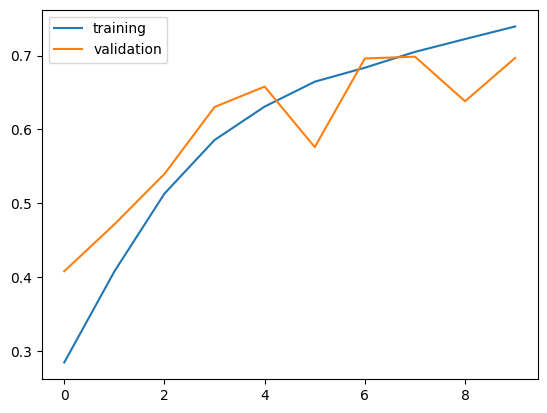

In [13]:
history = initial_model.fit(
        train_data,
        epochs=10,
        validation_data=val_data,
    )

plt.plot(history.history['accuracy'], label="training")
plt.plot(history.history['val_accuracy'], label="validation")
plt.legend()


With first simple model we get an accuracy of  between 0.6 and 0.7. Let's Tune parameters to improve it.

## Parameter Tunning

We will tune the learning rate, the inner layer size and the dropout rate.
We could tune more paremeters but we will stick to these three due to training time
1. learning rate: the learning rate (eta) is the most important value to adjust. Learning rate is like how fast we can read books. reading 1 book only a year is slow but we learn all the book,while if we read 1 every day maybe we do not get all the concepts, maybe we just check images and so. SO we need a medium speed
1. dropout rate: Dropuout is a way of regularizing. It is a way of preventing overfitting. Imagine that we have a tshirt with a logo. If we do many epochs, like 10, the model learns 10 times the same, and it can associate for example the logo with a tshirt. And if we see the logo  in a trouser, it could call it a tshirt. To fight this, we hide with a part of the image, for example, with a patch, so everytime it sees the image in each epoch, it will be slighly different. To do this, we can freeze different part of the network, like a neuron in the inner layer.
1. Inner layer size. Basically change the number of "neurons" of the inner layer to see if we need more due to complexity or less



In [14]:
def make_tunned_model(size_inner=64,learning_rate=0.01,dropout_rate=0.0):
    
    inputs = keras.Input(shape=(target_size[0], target_size[1], 3)) #matrix and all 3 colors (RGB)
    
    # convolute. Convert all values (pixesl) into single value
    conv = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs) 
    
    # reduce width and height
    pooling = keras.layers.MaxPool2D(strides=(2, 2))(conv)
    
    flatten = keras.layers.Flatten()(pooling)
    if dropout_rate != 0:
        dropout = keras.layers.Dropout(rate=dropout_rate)(flatten)
        dense = keras.layers.Dense(size_inner, activation='relu')(dropout)
    else:
        dense = keras.layers.Dense(size_inner, activation='relu')(flatten)
        
    #Reduce layers to number of classes
    outputs = keras.layers.Dense(len(classes), activation='softmax')(dense)
    
    model = keras.Model(inputs, outputs)
    
    ##############################################
    
    # optimizers use gradient descend
    # optimizers needs a way to know if it learns anything or not.
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
   
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=False) 
    # logits False because we have softmax in the output
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model


Let's tune learning rate first

In [ ]:
scores={}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_tunned_model(learning_rate=lr)
    history = model.fit(
        train_data,
        epochs=10,
        validation_data=val_data,
    )
    scores[lr] = history.history
    
    print()
    print()


0.0001
Epoch 1/10
810/810 [==============================] - 11s 13ms/step - loss: 2.2690 - accuracy: 0.1320 - val_loss: 2.2403 - val_accuracy: 0.1728
Epoch 2/10
810/810 [==============================] - 11s 13ms/step - loss: 2.2209 - accuracy: 0.2007 - val_loss: 2.2061 - val_accuracy: 0.2143
Epoch 3/10
810/810 [==============================] - 11s 13ms/step - loss: 2.1891 - accuracy: 0.2206 - val_loss: 2.1768 - val_accuracy: 0.2269
Epoch 4/10
810/810 [==============================] - 11s 13ms/step - loss: 2.1596 - accuracy: 0.2343 - val_loss: 2.1479 - val_accuracy: 0.2296
Epoch 5/10
810/810 [==============================] - 11s 13ms/step - loss: 2.1306 - accuracy: 0.2397 - val_loss: 2.1190 - val_accuracy: 0.2422
Epoch 6/10
810/810 [==============================] - 11s 13ms/step - loss: 2.1015 - accuracy: 0.2485 - val_loss: 2.0903 - val_accuracy: 0.2469
Epoch 7/10
810/810 [==============================] - 11s 13ms/step - loss: 2.0724 - accuracy: 0.2575 - val_loss: 2.0614 - val_ac

In [ ]:
def plot_accuracy(scores,title):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5),sharey=True)
    for label, hist in scores.items():
        ax1.plot(hist['accuracy'], label=label)
        ax2.plot(hist['val_accuracy'], label=label)
    ax1.legend()
    ax2.legend()
    #ax1.set_ylim([0.5,1])
    ax1.set_title("Training. {}".format(title))
    ax2.set_title("Validation. {}".format(title))


plot_accuracy(scores,"learning_rate")

# we can see that it is very close to 1 the training, while for validation not more than 80, which is overfitting.


In [ ]:
best_learning_rate = 0.01

Best learning rate is: 0.01

Now let's tune the dropout rate.

In [ ]:
scores={}

for dropout_rate in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print(dropout_rate)
    model = make_tunned_model(learning_rate=best_learning_rate, dropout_rate=dropout_rate)
    history = model.fit(
        train_data,
        epochs=10,
        validation_data=val_data,
    )
    scores[dropout_rate] = history.history
    
    print()
    print()

In [ ]:
plot_accuracy(scores,"dropout_rate")

In [ ]:
best_dropout_rate = 0.0

Best dropout rate is: 0.0. It looks like we do not need to regularize with dropout

Finally, let's tune the inner layer size.

In [ ]:
scores={}
for inner_size in [32, 64, 128, 256]:
    print(inner_size)
    model = make_tunned_model(size_inner = inner_size, learning_rate = best_learning_rate, dropout_rate = best_dropout_rate)
    history = model.fit(
        train_data,
        epochs=10,
        validation_data=val_data,
    )
    scores[inner_size] = history.history
    
    print()
    print()

In [ ]:
plot_accuracy(scores,"inner_size")

In [ ]:
best_inner_size = 128

Now we have a final model.

We will compare to an already created model like xception and apply transfer learning to see if it is better than our model.

Normally, the learning into vector representation of many models is very generic. But the dense layers afterwars are specific to the dataset.
SO we want to keep the convolutional layers (the first ones) and train the dense layers.
So we reuse the learning knowledge and that is transfer learning

In [ ]:
#Final value of paramenters:
print (best_learning_rate, best_inner_size, best_dropout_rate)

### Regularization: Data augmentation

Now, let's do data augmentation

this is another way for regularization. We generate more data from existing data. This also prevents from seeing the same image over and over again.


In [ ]:
augmented_train_gen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=30,
    #width_shift_range=10.0,
    #height_shift_range=10.0,
    shear_range=10,
    zoom_range=0.1,
    vertical_flip=True,
  )


# we do not apply augmentation to the validation because we want to compare with something consistent always

augmented_train_data = augmented_train_gen.flow_from_directory(
    "train/",
    target_size=target_size,
    batch_size=20,
    shuffle=True
)
scores={}
model = make_tunned_model(size_inner = best_inner_size, learning_rate = best_learning_rate, dropout_rate = best_dropout_rate)
history = model.fit(
    augmented_train_data,
    epochs=10,
    validation_data=val_data,
)
scores["augmented"] = history.history

print()
print()

In [ ]:
plot_accuracy(scores,"augmented")

Augmentation does not really help. We get similar or less accuracy 




## Final model

Let's just create our final model.

Also, let's create checkpoints to get the model with the best accuracy.

Checpointing means saving the model in the iterations with highest scores, like the peaks in the plots when training.

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'map_model_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True, #this is a variable that saves when it is the best compared to the past models
    monitor='val_accuracy',
    mode='max'
)
checkpoint_final = keras.callbacks.ModelCheckpoint(
    'final-map-model.h5',
    save_best_only=True, #this is a variable that saves when it is the best compared to the past models
    monitor='val_accuracy',
    mode='max'
)

let's add more epochs for a bigger training

In [ ]:
model = make_tunned_model(size_inner = best_inner_size, learning_rate = best_learning_rate, dropout_rate = best_dropout_rate)
scores={}
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[checkpoint_final]
)
scores["final_model"] = history.history


In [ ]:
plot_accuracy(scores,"final_model")

## TEST our model

In [ ]:
test_datagenerator = ImageDataGenerator(rescale=1./255)

test_data = test_datagenerator.flow_from_directory(
    "test/",
    target_size=target_size,
    batch_size=20,
    shuffle=False # no need to shuffle for test
)


In [ ]:
final_model.evaluate(test_data) # first number is categorical crossentropy, the second is the accuracy.

Our model has an accuracy of: 

### Prediction on a single image by final model

In [ ]:
from keras.preprocessing import image

img = load_img('test/Industrial/Industrial_89.jpg',target_size=target_size)
img

In [ ]:
X = np.array([img])
pred = model.predict(X)
print (class_pred_dict[np.argmax(pred,axis=1)[0]])

# Prediction of all test images

In [ ]:
pred_test = model.predict_generator(test_data)
predicted_class_indices_test = np.argmax(pred_test,axis=1)
predictions = [class_pred_dict[p] for p in predicted_class_indices_test]
cm = confusion_matrix([class_pred_dict[p] for p in predicted_class_indices_test], 
                 [class_pred_dict[l] for l in test_data.labels], 
                 labels=list(class_pred_dict.values()))
print(f'accuracy: {sum(predicted_class_indices_test == test_data.labels) / len(predicted_class_indices_test)}')


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, linewidths=0.1)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(list(class_pred_dict.values()))
ax.yaxis.set_ticklabels(list(class_pred_dict.values()))